In [42]:
#pip install pandas pillow matplotlib

In [43]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [44]:
# Set dataset path
DATA_DIR = Path("../data/raw/")
print(f"Dataset root: {DATA_DIR.resolve()}")

# Define splits to explore
splits = ["train", "val", "test"]  # some versions use "val" instead of "validation"

# Collect image paths with split info
image_records = []
for split in splits:
    split_path = DATA_DIR / split
    if not split_path.exists():
        continue  # skip if not present
    for img_path in split_path.rglob("*.jpg"):
        # For train/val — label is folder name; for test, label may not exist
        label = img_path.parent.name if split != "test" else "unlabeled"
        image_records.append({
            "filepath": str(img_path),
            "split": split,
            "label": label
        })

df_images = pd.DataFrame(image_records)
print(f"✅ Total images found: {len(df_images):,}")
df_images.head()

Dataset root: C:\Users\ASUS\Jupyter\image colourisation\Image-Colourisation\data\raw
✅ Total images found: 1,839,960


,filepath,split,label
0,..\data\raw\train\airfield\00000001.jpg,train,airfield
1,..\data\raw\train\airfield\00000002.jpg,train,airfield
2,..\data\raw\train\airfield\00000003.jpg,train,airfield
3,..\data\raw\train\airfield\00000004.jpg,train,airfield
4,..\data\raw\train\airfield\00000005.jpg,train,airfield


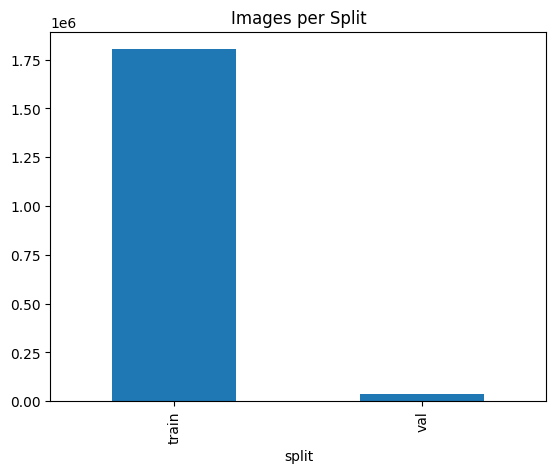

split
train    1803460
val        36500
Name: count, dtype: int64


In [50]:
df_images["split"].value_counts().plot(kind="bar", title="Images per Split")
plt.show()
print(df_images["split"].value_counts())

Number of training classes: 365


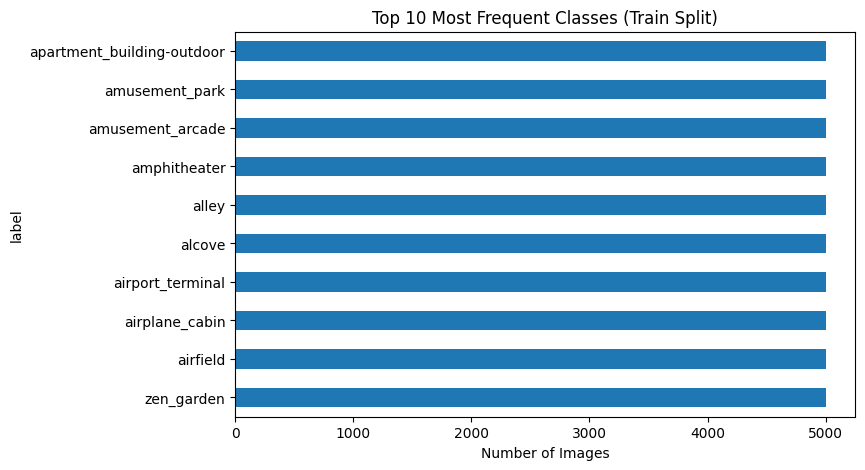

In [46]:
train_classes = df_images[df_images["split"] == "train"]["label"].value_counts()
print(f"Number of training classes: {len(train_classes)}")

train_classes.head(10).plot(kind="barh", figsize=(8, 5))
plt.title("Top 10 Most Frequent Classes (Train Split)")
plt.xlabel("Number of Images")
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5936\2332797722.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df_images.groupby("split", group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))


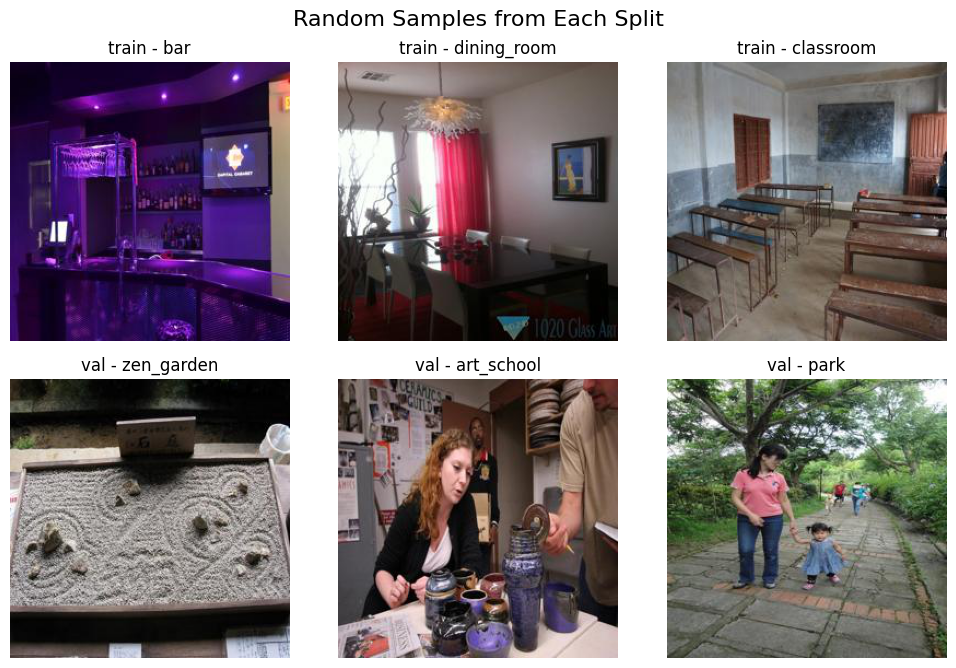

In [47]:
n_samples = 9
sampled = df_images.groupby("split", group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(sampled.iterrows()):
    img = Image.open(row["filepath"]).convert("RGB")
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row['split']} - {row['label']}")
    plt.axis("off")

plt.suptitle("Random Samples from Each Split", fontsize=16)
plt.tight_layout()
plt.show()


In [48]:
def get_image_stats(paths, n=1000):
    widths, heights = [], []
    for img_path in tqdm(random.sample(paths, min(n, len(paths))), desc="Measuring image dimensions"):
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    return pd.DataFrame({"width": widths, "height": heights})

train_dims = get_image_stats(df_images[df_images["split"] == "train"]["filepath"].tolist())
train_dims.describe()


Measuring image dimensions: 100%|██████████| 1000/1000 [00:08<00:00, 120.01it/s]


,width,height
count,1000.0,1000.0
mean,256.0,256.0
std,0.0,0.0
min,256.0,256.0
25%,256.0,256.0
50%,256.0,256.0
75%,256.0,256.0
max,256.0,256.0


In [49]:
def image_color_stats(img_path):
    img = np.array(Image.open(img_path).convert("RGB")) / 255.0
    r, g, b = img[..., 0], img[..., 1], img[..., 2]
    return np.mean(r), np.mean(g), np.mean(b)

sample_paths = random.sample(df_images["filepath"].tolist(), min(500, len(df_images)))
color_means = np.array([image_color_stats(p) for p in sample_paths])
df_colors = pd.DataFrame(color_means, columns=["R_mean", "G_mean", "B_mean"])
df_colors.describe()


,R_mean,G_mean,B_mean
count,500.000000,500.000000,500.000000
mean,0.452546,0.433701,0.396681
std,0.122025,0.121782,0.137438
min,0.031979,0.080693,0.049769
25%,0.375214,0.361061,0.305461
50%,0.454099,0.442248,0.400212
75%,0.527165,0.511255,0.482459
max,0.810556,0.792305,0.834889


## Summary

- Total images: 1,839,960
- Splits:
  - Train: 1,803,460
  - Validation: -
  - Test: 36,500
- Classes: 365 scene types
- Average image size: 256×256 pixels
